In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from tqdm import tqdm

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [2]:
filename = '/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/Fkh_Mass_Spec_edited.csv'
df = pd.read_csv(filename)
df.columns
df = df.rename(columns={'Gene names  (ordered locus )':'gene_name'})
df['gene_name'] = df['gene_name'].astype(str)
df = df.drop_duplicates(subset='gene_name')
df = df.set_index('gene_name')
df = df.drop('nan')

<Axes: xlabel='exp1', ylabel='exp2'>

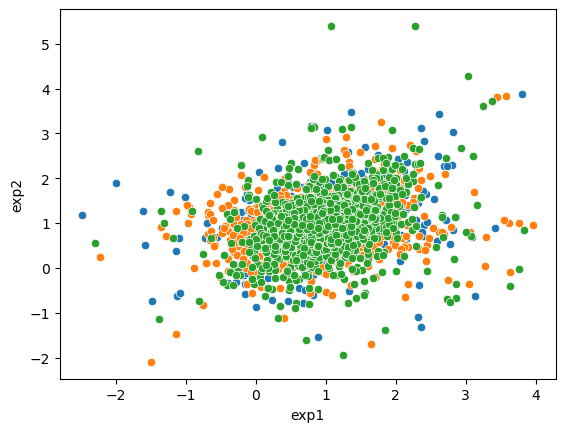

In [3]:

wt_slopes = df[['WT_Slope_Expt1','WT_Slope_Expt2']]
wt_slopes = wt_slopes.rename(columns={'WT_Slope_Expt1':'exp1','WT_Slope_Expt2':'exp2'})
fkh1_slopes = df[['fkh1_Slope_Expt1','fkh1_Slope_Expt2']]
fkh1_slopes = fkh1_slopes.rename(columns={'fkh1_Slope_Expt1':'exp1','fkh1_Slope_Expt2':'exp2'})
fkh2_slopes = df[['fkh2_Slope_Expt1','fkh2_Slope_Expt2']]
fkh2_slopes = fkh2_slopes.rename(columns={'fkh2_Slope_Expt1':'exp1','fkh2_Slope_Expt2':'exp2'})

sb.scatterplot(wt_slopes,x='exp1',y='exp2')
sb.scatterplot(fkh1_slopes,x='exp1',y='exp2')
sb.scatterplot(fkh2_slopes,x='exp1',y='exp2')


<Axes: xlabel='fkh2_del', ylabel='fkh1_del'>

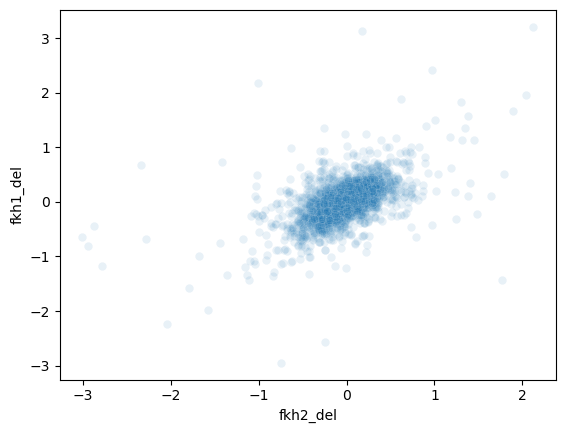

In [4]:
delta_slopes = pd.DataFrame()
delta_slopes['WT'] = df['WT_Slope_Avg']
delta_slopes['fkh1_del'] = df['WT_Slope_Avg'] - df['fkh1_Slope_Avg']
delta_slopes['fkh2_del'] = df['WT_Slope_Avg'] - df['fkh2_Slope_Avg']

sb.scatterplot(delta_slopes,x='fkh2_del',y='fkh1_del',alpha=0.1)

In [178]:
# Grab promoter sequences

from random import sample
from os import path
from re import findall
import matplotlib.pyplot as plt
from glob import glob

from pyfaidx import Fasta

dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Bioinformatics/Whi5/'

#23288841 is Sc assemblyID
yeast_genome = glob(path.join(dirname,f'Genomes/23288841/GCF_000146045.2_R64_genomic.fa'))
yeast_genome = Fasta(yeast_genome[0])

# All promoters from SCG
promoters = glob(path.join(dirname,f'all_S228C_ORFs/orf_genomic_1000_all.fasta'))
promoters = Fasta(promoters[0])
                     
Fkh = pd.read_csv(path.join(dirname,'FKH2_pwm.txt'),sep='\t',index_col=0,header=None).T

def get_pswm_score(mat,seq):
    L = len(mat)
    N = len(seq)
    return np.array([ np.sum([mat.loc[k,v] for k,v in enumerate( list(seq[i:i+L]) )]) for i in range(N-L) ])


In [7]:
higher_slope_12 = delta_slopes[(delta_slopes['fkh1_del'] > 0.5) & (delta_slopes['fkh2_del'] > 0.5)]
middle_slope_12 = delta_slopes[(delta_slopes['fkh1_del'] > -0.01) & (delta_slopes['fkh2_del'] < 0.01)]
lower_slope_12 = delta_slopes[(delta_slopes['fkh1_del'] < -0.5) & (delta_slopes['fkh2_del'] < -0.5)]

promoters['YOR385W']

higher_slope_promoters = [SeqRecord( Seq(promoters[name][:1000].seq), id=name) for name,_ in higher_slope_12.iterrows()]

lower_slope_promoters = [SeqRecord( Seq(promoters[name][:1000].seq), id=name) for name,_ in lower_slope_12.iterrows()]

middle_slope_promoters = [SeqRecord( Seq(promoters[name][:1000].seq), id=name) for name,_ in middle_slope_12.iterrows()
                         if not name == 'R0020C']


In [287]:
len(lower_slope_promoters)

66

In [8]:
# Export top and bottom for MEME discovery
from Bio import SeqIO

SeqIO.write(higher_slope_promoters, '/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/Fkh12del_higher_slopes.fasta', "fasta")
SeqIO.write(lower_slope_promoters, '/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/Fkh12del_lower_slopes.fasta', "fasta")
SeqIO.write(middle_slope_promoters, '/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/Fkh12del_middle_slopes.fasta', "fasta")

806

In [58]:
# Load PSWM for Fkh1
Fkh = pd.read_csv(path.join(dirname,'FKH1_pwm.txt'),sep='\t',index_col=0,header=None).T
entropy = -np.sum(Fkh*np.log(Fkh),axis=1)
high_entropy_positions = [1,2,10,11,12]
Fkh = Fkh.drop(labels=high_entropy_positions).reset_index().drop(columns='index')
L = len(Fkh)

# 'promoters' is from SGD with 1000 upstream of every ORF; per JK, trimmed to 500bp upstream of TSS
for gene in tqdm(delta_slopes.index):
    if gene in promoters.keys():
        seq = promoters[gene][500:1000].seq
#        df.loc[gene,'Fkh1 score'] = get_pswm_score(Fkh,seq).mean()
        delta_slopes.loc[gene,'Fkh1 score'] = get_pswm_score(Fkh,seq).mean()

# Load PSWM for Fkh2
Fkh = pd.read_csv(path.join(dirname,'FKH2_pwm.txt'),sep='\t',index_col=0,header=None).T
entropy = -np.sum(Fkh*np.log(Fkh),axis=1)
high_entropy_positions = [1,2,10,11,12]
Fkh = Fkh.drop(labels=high_entropy_positions).reset_index().drop(columns='index')
L = len(Fkh)

# 'promoters' is from SGD with 1000 upstream of every ORF; per JK, trimmed to 500bp upstream of TSS
for gene in tqdm(delta_slopes.index):
    if gene in promoters.keys():
        seq = promoters[gene][500:1000].seq
#        df.loc[gene,'Fkh2 score'] = get_pswm_score(Fkh,seq).mean()
        delta_slopes.loc[gene,'Fkh2 score'] = get_pswm_score(Fkh,seq).mean()

100%|██████████████████████████████████████| 3978/3978 [00:36<00:00, 108.80it/s]


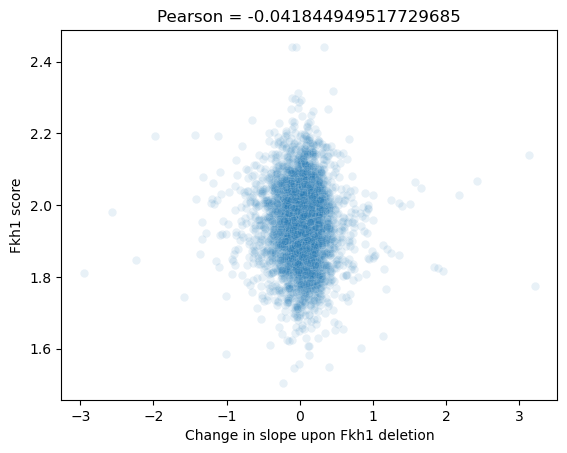

In [65]:
sb.scatterplot(delta_slopes,x='fkh1_del',y='Fkh1 score',alpha=0.1)
R,P = np.corrcoef(delta_slopes.dropna()['fkh1_del'],delta_slopes.dropna()['Fkh1 score'])
plt.title(f'Pearson = {R[1]}')
plt.xlabel('Change in slope upon Fkh1 deletion')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/delta_slope_1del_v_1score.svg', format='svg')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/delta_slope_1del_v_1score.png', format='png')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


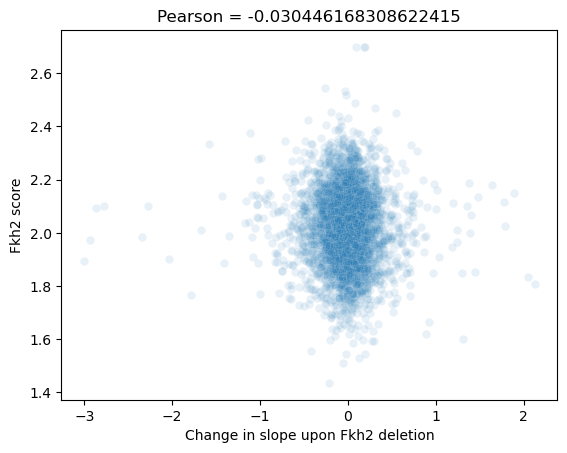

In [64]:
sb.scatterplot(delta_slopes,x='fkh2_del',y='Fkh2 score',alpha=0.1)
R,P = np.corrcoef(delta_slopes.dropna()['fkh2_del'],delta_slopes.dropna()['Fkh2 score'])
plt.title(f'Pearson = {R[1]}')
plt.xlabel('Change in slope upon Fkh2 deletion')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/delta_slope_2del_v_2score.png', format='png')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/delta_slope_2del_v_2score.eps', format='eps')

In [184]:
'''

Truncate the motifs to ~AAACA

'''

# Load PSWM for Fkh1
Fkh = pd.read_csv(path.join(dirname,'FKH1_pwm.txt'),sep='\t',index_col=0,header=None).T
entropy = -np.sum(Fkh*np.log(Fkh),axis=1)
high_entropy_positions = [1,2,3,4,10,11,12]
Fkh = Fkh.drop(labels=high_entropy_positions).reset_index().drop(columns='index')
L = len(Fkh)

#print logo
#from Bio import motifs
Fkh # AACAA

for gene in tqdm(delta_slopes.index):
    if gene in promoters.keys():
        seq = promoters[gene][500:1000].seq
#        df.loc[gene,'Truncated Fkh1 score'] = get_pswm_score(Fkh,seq).mean()
        delta_slopes.loc[gene,'Truncated Fkh1 score v2'] = get_pswm_score2(Fkh,seq).mean()

100%|█████████████████████████████████████| 3978/3978 [00:02<00:00, 1614.26it/s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


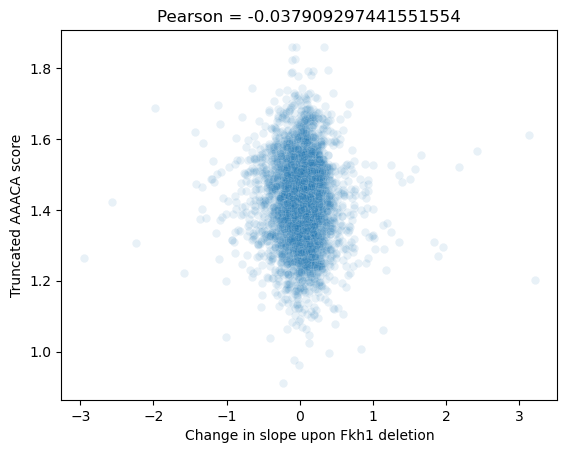

In [187]:
sb.scatterplot(delta_slopes,x='fkh1_del',y='Truncated Fkh1 score v2',alpha=0.1)
R,P = np.corrcoef(delta_slopes.dropna()['fkh1_del'],delta_slopes.dropna()['Truncated Fkh1 score'])
plt.title(f'Pearson = {R[1]}')
plt.ylabel('Truncated AAACA score')
plt.xlabel('Change in slope upon Fkh1 deletion')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/delta_slope_2del_v_AAACAscore.png', format='png')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/delta_slope_2del_v_AAACAscore.eps', format='eps')

In [232]:
'''

Load all motifs

'''

from glob import glob
from os import path

filenames = glob('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/curated PWMs/ALIGNED_ENOLOGO_FORMAT_PWMS/*.pwm')
motifs = {}

for f in filenames:
    basename = path.splitext(path.split(f)[1])[0]
    tf_name,motif_name = basename.split('_')
    _df = pd.read_csv(f,sep='\t',index_col=0, header=None).T.reset_index(drop=True)
    motifs[(tf_name,motif_name)] = _df


def get_pswm_score_fast(mat: pd.DataFrame, seq: str):
    L = len(mat)
    N = len(seq)
    A = mat.columns

    # Create a lookup table: character to column index
    col_lookup = {c: i for i, c in enumerate(A)}

    # Convert sequence to numeric indices
    seq_idx = np.array([col_lookup[c] for c in seq])

    # Extract sliding windows (N-L+1, L)
    windows = np.lib.stride_tricks.sliding_window_view(seq_idx, window_shape=L)

    # Now we need to look up mat.loc[k, v] for each position k and base v
    # windows.shape = (N-L+1, L)
    # So we construct two arrays:
    #   rows = [0, 1, 2, ..., L-1]
    #   cols = windows[i, :]
    row_idx = np.arange(L)  # Shape (L,)
    scores = np.array([mat.values[row_idx, win] for win in windows])

    return scores.sum(axis=1)


In [233]:
motifs

{('YGR249W',
  '2141'): 0         A         T         G         C
 0 -0.261057 -0.347619  0.589481  0.156673
 1 -0.782486 -0.032285  0.443153  0.443153
 2 -0.215305 -0.806810  0.808357  0.231279
 3 -1.555734  1.372937 -1.642947 -2.623980
 4 -2.068414  1.523897 -4.622636 -2.819267
 5 -1.791685 -2.224494 -2.398269  2.088513
 6 -1.671637  0.247148  0.434046  0.549462
 7 -0.069001 -0.429675  0.319875  0.319875
 8 -0.742041  0.440969 -0.598423  0.498025
 9 -0.122985 -0.526940  0.540003  0.237037,
 ('YGL192W',
  '1000'): 0         A           T           G           C
 0  1.059609   -0.425817   -1.626439   -1.626439
 1  1.621488   -2.747745 -800.000000 -800.000000
 2 -4.332708    0.422180    1.583014 -800.000000
 3 -4.332708   -1.525353    1.695489    0.461024
 4  1.689660 -800.000000 -800.000000 -800.000000
 5  0.989220    0.311148 -800.000000 -800.000000
 6  1.667292   -4.332708 -800.000000 -800.000000
 7  1.126724   -0.873276   -0.304511 -800.000000,
 ('YPL128C',
  '2178'): 0         A   

In [246]:
# Find tf that has maximum motifID (don't know how it's ordered)

motif_manifest = pd.DataFrame()
motif_manifest['Gene name'] = [g for g,m in motifs.keys()]
motif_manifest['MotifID'] = [m for g,m in motifs.keys()]

grouped = [m for gene_name, m in motif_manifest.groupby('Gene name')]

print(f'Total of {len(motif_manifest)} motifs for {len(motif_manifest['Gene name'].unique())} TFs')

Total of 244 motifs for 206 TFs


In [247]:
# Do run motif score and correlate with slope change

motif_correlations = pd.DataFrame(columns=['Fkh1del_correlation','Fkh2del_correlation'],
                                 index=motifs2run['Gene name'])

motif_correlations.loc['Fkh1','Fkh1del_correlation'] = np.corrcoef(delta_slopes.dropna()['Fkh1 score'],
                                                                   delta_slopes.dropna()['fkh1_del'])[0][1]
motif_correlations.loc['Fkh1','Fkh2del_correlation'] = np.corrcoef(delta_slopes.dropna()['Fkh1 score'],
                                                                   delta_slopes.dropna()['fkh2_del'])[0][1]
motif_correlations.loc['Fkh2','Fkh1del_correlation'] = np.corrcoef(delta_slopes.dropna()['Fkh2 score'],
                                                                   delta_slopes.dropna()['fkh1_del'])[0][1]
motif_correlations.loc['Fkh2','Fkh2del_correlation'] = np.corrcoef(delta_slopes.dropna()['Fkh2 score'],
                                                                   delta_slopes.dropna()['fkh2_del'])[0][1]

gene2test = [gene for gene in delta_slopes.dropna().index if gene in promoters.keys()]

In [253]:

for _,m in tqdm(motif_manifest.iterrows()):
    gene_name = m['Gene name']
    motifID = m['MotifID']
    motif = motifs[(gene_name,motifID)]

    scores = np.array([ get_pswm_score_fast(motif, promoters[gene][500:1000].seq).mean()
                      for gene in delta_slopes.dropna().index if gene in promoters.keys()])
    
    R,P = np.corrcoef(scores,delta_slopes.loc[gene2test,'fkh1_del'].values)
    motif_correlations.loc[gene_name, 'Fkh1del_correlation'] = R[1]
    R,P = np.corrcoef(scores,delta_slopes.loc[gene2test,'fkh2_del'].values)
    motif_correlations.loc[gene_name, 'Fkh2del_correlation'] = R[1]
    

244it [09:08,  2.25s/it]


In [262]:
motif_correlations = motif_correlations.drop_duplicates()

Index(['YGR249W', 'YPL128C', 'YGL192W', 'Fkh1', 'Fkh2', 'YOR230W', 'YJL127C',
       'YKL043W', 'YOR172W', 'YOR337W',
       ...
       'YGL013C', 'YML007W', 'YLR014C', 'YLR375W', 'YPL202C', 'TBP-TFIIB',
       'YCL055W', 'YEL009C', 'YKL185W', 'YMR168C'],
      dtype='object', name='Gene name', length=208)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


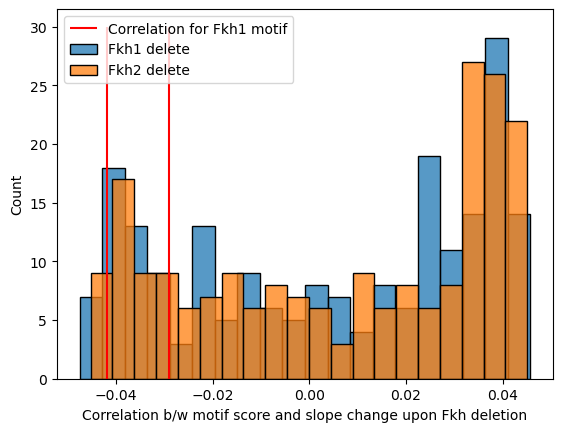

In [283]:
sb.histplot(motif_correlations,x='Fkh1del_correlation',bins=20)
sb.histplot(motif_correlations,x='Fkh2del_correlation',bins=20)
plt.xlabel('Correlation b/w motif score and slope change upon Fkh deletion')
plt.vlines(motif_correlations.loc['Fkh1'],ymin=0,ymax=30,color='r')
plt.legend(['Correlation for Fkh1 motif','Fkh1 delete','Fkh2 delete'])

plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/all_PWM_correlation_with_fkhslopechange.png', format='png')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/all_PWM_correlation_with_fkhslopechange.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


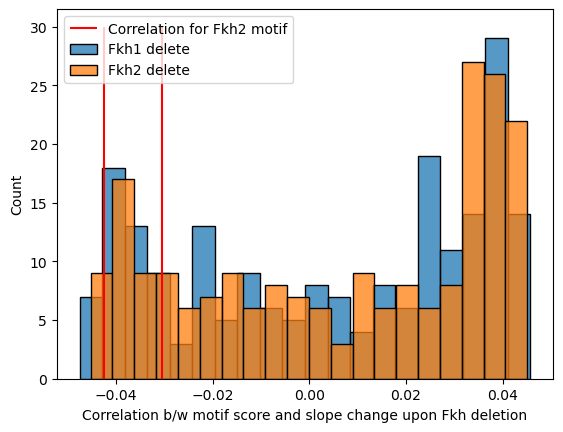

In [284]:
sb.histplot(motif_correlations,x='Fkh1del_correlation',bins=20)
sb.histplot(motif_correlations,x='Fkh2del_correlation',bins=20)
plt.xlabel('Correlation b/w motif score and slope change upon Fkh deletion')
plt.vlines(motif_correlations.loc['Fkh2'],ymin=0,ymax=30,color='r')
plt.legend(['Correlation for Fkh2 motif','Fkh1 delete','Fkh2 delete'])

plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/all_PWM_correlation_with_fkhslopechange_fkh2highlighted.png', format='png')
plt.savefig('/Users/xies/OneDrive - Stanford/Bioinformatics/Fkh RNAseq/all_PWM_correlation_with_fkhslopechange_fkh2highlighted.eps', format='eps')

<Axes: xlabel='Fkh1del_correlation', ylabel='Fkh2del_correlation'>

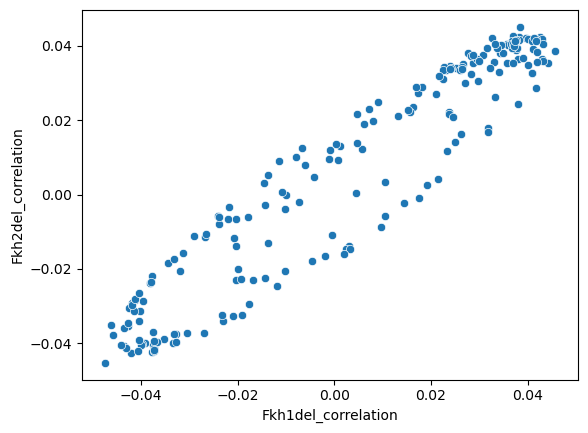

In [265]:

sb.scatterplot(motif_correlations,x='Fkh1del_correlation',y='Fkh2del_correlation')

In [281]:
print('---TF motifs presence that anti-correlate with slope change---')
print(motif_correlations.sort_values('Fkh1del_correlation').head(10))
print('---TF motifs presence that correlate with slope change---')
print(motif_correlations.sort_values('Fkh1del_correlation').tail(10))

---TF motifs presence that anti-correlate with slope change---
                     Fkh1del_correlation Fkh2del_correlation
Gene name                                                   
YGL073W                        -0.047516           -0.045229
YMR043W                        -0.046194           -0.035096
YPR065W                        -0.045777           -0.037648
YCR039C                        -0.044147           -0.040521
YDR266C                        -0.043584            -0.03598
YNL139C                         -0.04355            -0.04079
YML027W                        -0.043116           -0.041308
YNL314W                        -0.042762           -0.034624
MATALPHA1-MCM1-dimer           -0.042639           -0.035357
Fkh2                           -0.042486           -0.030446
---TF motifs presence that correlate with slope change---
          Fkh1del_correlation Fkh2del_correlation
Gene name                                        
YER111C              0.041785            0.0286

In [267]:
print(motif_correlations.sort_values('Fkh2del_correlation').head(10))
print(motif_correlations.sort_values('Fkh2del_correlation').tail(10))

          Fkh1del_correlation Fkh2del_correlation
Gene name                                        
YGL073W             -0.047516           -0.045229
YGL192W             -0.041971           -0.042538
YDR034C             -0.037748           -0.042265
YER068W             -0.040696           -0.042025
YER051W             -0.037376           -0.041947
YER045C             -0.037344           -0.041727
YDR310C             -0.037381           -0.041318
YML027W             -0.043116           -0.041308
YNL139C              -0.04355            -0.04079
YCR039C             -0.044147           -0.040521
          Fkh1del_correlation Fkh2del_correlation
Gene name                                        
YMR280C              0.040085            0.041745
YDR303C              0.040282            0.041777
YBR150C              0.041646            0.041955
YHR206W              0.039618            0.042019
YER064C              0.032689            0.042121
YHR006W              0.041411            0.042211
